# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [1]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [4]:
# TODO: load the air temperature and precipitation datasets.
# Define chunk size for time (adjust based on memory limits and analysis needs)
chunk_size = 10

# Open both datasets with chunking on time
air = xr.open_dataset(TEMP_URL, chunks={"time": chunk_size})
precip = xr.open_dataset(PRECIP_URL, chunks={"time": chunk_size})

# Example: air = xr.open_dataset(..., chunks={"time": 8})
# raise NotImplementedError("Assign datasets to `air` and `precip`.")


## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [5]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.

# Check latitude direction
if air.lat.size > 0:
    print("air lat ascending:", air.lat.values[0] < air.lat.values[-1])
else:
    print("air lat is empty")

if precip.lat.size > 0:
    print("precip lat ascending:", precip.lat.values[0] < precip.lat.values[-1])
else:
    print("precip lat is empty")

# Check longitude direction
if air.lon.size > 0:
    print("air lon ascending:", air.lon.values[0] < air.lon.values[-1])
else:
    print("air lon is empty")

if precip.lon.size > 0:
    print("precip lon ascending:", precip.lon.values[0] < precip.lon.values[-1])
else:
    print("precip lon is empty")

# Latitude slice
lat_slice_air = slice(20, 50) if air.lat.values[0] < air.lat.values[-1] else slice(50, 20)
lat_slice_precip = slice(20, 50) if precip.lat.values[0] < precip.lat.values[-1] else slice(50, 20)

# Longitude slice
lon_slice_air = slice(230, 300) if air.lon.values[0] < air.lon.values[-1] else slice(300, 230)
lon_slice_precip = slice(230, 300) if precip.lon.values[0] < precip.lon.values[-1] else slice(300, 230)

air_us = air.sel(time=TIME_RANGE, lat=lat_slice_air, lon=lon_slice_air)
precip_us = precip.sel(time=TIME_RANGE, lat=lat_slice_precip, lon=lon_slice_precip)

#raise NotImplementedError("Create `air_us` and `precip_us`.")

air lat ascending: False
precip lat ascending: False
air lon ascending: True
precip lon ascending: True


## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [6]:
# TODO: use xr.resample to create daily means.

# Aggregate six-hourly air temperatures to daily means
air_daily = air_us["air"].resample(time="1D").mean()

# raise NotImplementedError("Create `air_daily`.")


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [7]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.

# Interpolate daily air temperatures onto the precipitation grid
air_interp = air_daily.interp(
    lat=precip_us.lat,
    lon=precip_us.lon,
    method="linear"
)

# raise NotImplementedError("Create `air_interp`.")

## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [10]:
# TODO: build datasets and merge them into one object named `merged`.

# Convert aligned arrays into datasets with clear variable names
air_ds = xr.Dataset({"air_temperature": air_interp})
precip_ds = xr.Dataset({"daily_precip": precip_us["precip"]})

# Merge the datasets
merged = xr.merge([air_ds, precip_ds])

# raise NotImplementedError("Create `merged`.")

## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [11]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


# Render both Variables on a Cartopy Map

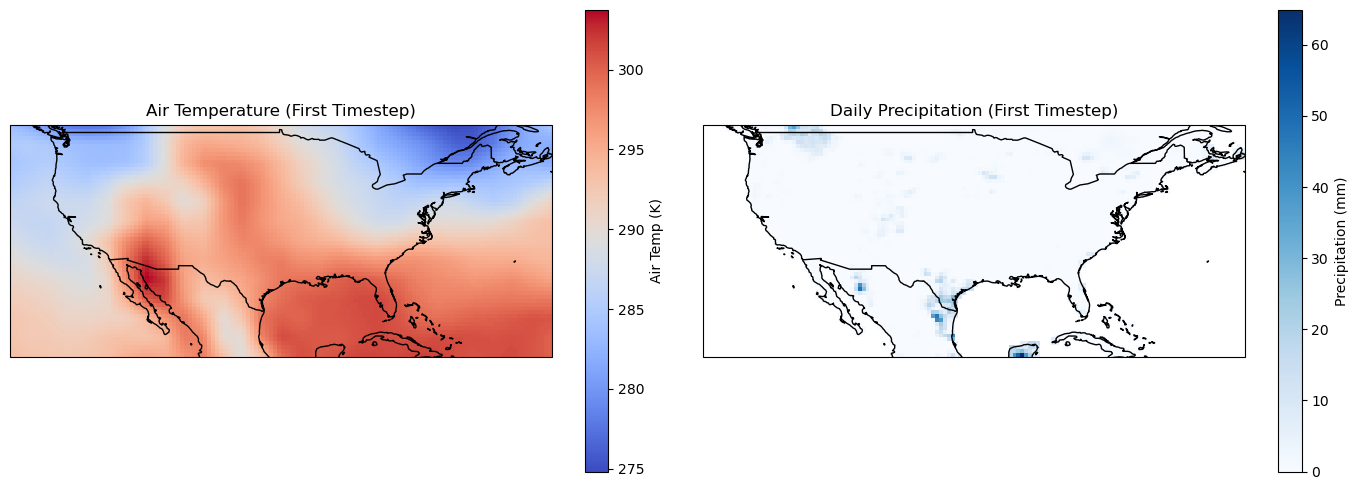

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Select first timestep
t0 = merged.time[0]

# Set up map projection
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={"projection": proj})

# Plot air temperature
merged.air_temperature.sel(time=t0).plot(
    ax=axes[0], transform=proj, cmap="coolwarm", cbar_kwargs={"label": "Air Temp (K)"}
)
axes[0].set_title("Air Temperature (First Timestep)")
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS)

# Plot precipitation
merged.daily_precip.sel(time=t0).plot(
    ax=axes[1], transform=proj, cmap="Blues", cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[1].set_title("Daily Precipitation (First Timestep)")
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS)

plt.tight_layout()
plt.show()


# Scatter Plot of Colocated Values

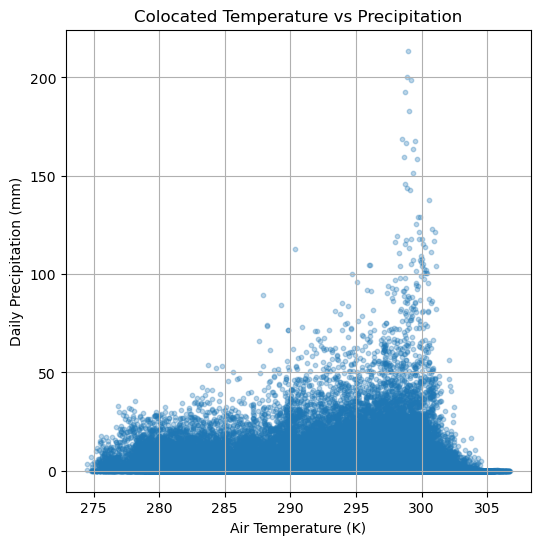

In [14]:
import numpy as np

# Flatten both arrays and drop NaNs
temp_vals = merged.air_temperature.values.flatten()
precip_vals = merged.daily_precip.values.flatten()

# Mask out NaNs
mask = ~np.isnan(temp_vals) & ~np.isnan(precip_vals)

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(temp_vals[mask], precip_vals[mask], alpha=0.3, s=10)
plt.xlabel("Air Temperature (K)")
plt.ylabel("Daily Precipitation (mm)")
plt.title("Colocated Temperature vs Precipitation")
plt.grid(True)
plt.show()


# Save Merged Dataset for Future Use

In [15]:
# Save to NetCDF file
merged.to_netcdf("merged_climate_data_june2020.nc")
